In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from typing import List, Tuple
import numpy as np
from torch.utils.data import ConcatDataset
import copy
import os
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import torch.nn.functional as F
import random
import sys
sys.path.append('../')
from utils import BrainGraphDataset, project_root
from models import VGAE


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# set the random seed for reproducibility
torch.manual_seed(0)

# define the hyperparameters
input_dim = 100  # size of the graph adjacency matrix
hidden_dim = 32
latent_dim = 64
lr = 1e-2
batch_size = 64
num_epochs = 500

annotations = 'annotations.csv'
root = project_root()

dataroot = 'fc_matrices/psilo_schaefer_before/'
schaefer_dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=None, setting='graph')

dataroot = 'fc_matrices/psilo_aal_before/'
aal_dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=None, setting='graph')

dataroot = 'fc_matrices/psilo_ica_100_before/'
psilo_ica_dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=None, setting='graph')

dataroot = 'fc_matrices/hcp_100_ica/'

atlases = ['ica', 'schaefer', 'aal']
datasets = [psilo_ica_dataset, schaefer_dataset, aal_dataset]

# for i, dataset in enumerate(datasets):

#     # split the dataset into training and validation sets
#     num_samples = len(dataset)
#     train_size = int(0.8 * num_samples)
#     val_size = num_samples - train_size
#     torch.manual_seed(0)
#     train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#     # define the data loaders
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size)

#     # define a dictionary to store the loss curves for each configuration
#     loss_curves = {}

#     best_val_loss = float('inf')  # set to infinity to start
#     best_model_state = None
#     train_losses = []
#     val_losses = []
    
#     num_nodes = 116 if atlases[i] == 'aal' else 100
    
#     model = VGAE(1, 1, num_nodes, 32, 8, device, dropout=0,
#                  l2_strength=0.001, use_nf=False).to(device)  # move model to device
#     print(model)
#     src, dest = model.edge_index
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     for epoch in tqdm(range(num_epochs)):
#         train_loss = 0.0
#         val_loss = 0.0

#         # training
#         model.train()
#         for batch_idx, ((graph), _) in enumerate(train_loader):
#             graph = graph.to(device)  # move data to device
#             optimizer.zero_grad()

#             rcn_edges, z, mu, logvar = model(None, graph)
#             graph = graph[:, src, dest]

#             (mse_edges, kl_loss, l2_reg) = model.loss(None, None, rcn_edges.view(graph.shape), graph,
#                                                              mu, logvar)
#             loss = mse_edges + kl_loss + l2_reg
#             loss.backward()
#             optimizer.step()
#             train_loss += mse_edges.item()

#         # validation
#         model.eval()
#         with torch.no_grad():
#             for batch_idx, ((graph), _) in enumerate(val_loader):
#                 graph = graph.to(device)  # move data to device

#                 rcn_edges, z, mu, logvar = model(None, graph)
#                 graph = graph[:, src, dest]

#                 (mse_edges, kl_loss, l2_reg) = model.loss(None, None, rcn_edges.view(graph.shape), graph,
#                                                                  mu, logvar)
#                 loss = mse_edges + kl_loss + l2_reg
#                 val_loss += mse_edges.item()
#         # append losses to lists
#         train_losses.append(train_loss/len(train_dataset))
#         val_losses.append(val_loss/len(val_dataset))

#         if (epoch + 1) % 20 == 0:
#             print(train_losses[-1], val_losses[-1])
#         # save the model if the validation loss is at its minimum
#         if val_losses[-1] < best_val_loss:
#             best_val_loss = val_losses[-1]
#             best_model_state = copy.deepcopy(model.state_dict())

#     print(best_val_loss)
#     # save the best model for this configuration
#     torch.save(best_model_state, os.path.join(root, f'vgae_weights/vgae_no_nf_{atlases[i]}_32_8.pt'))

cpu


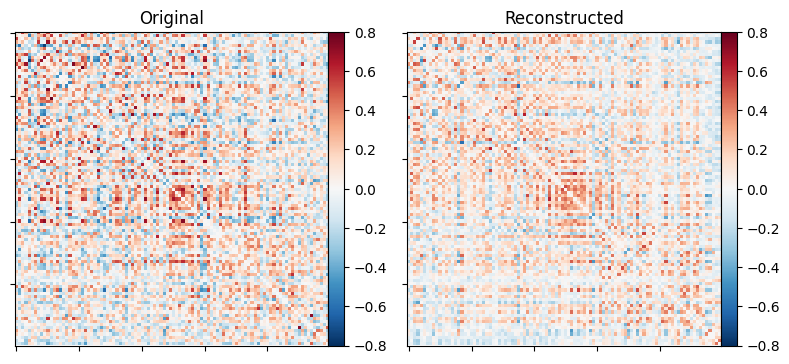

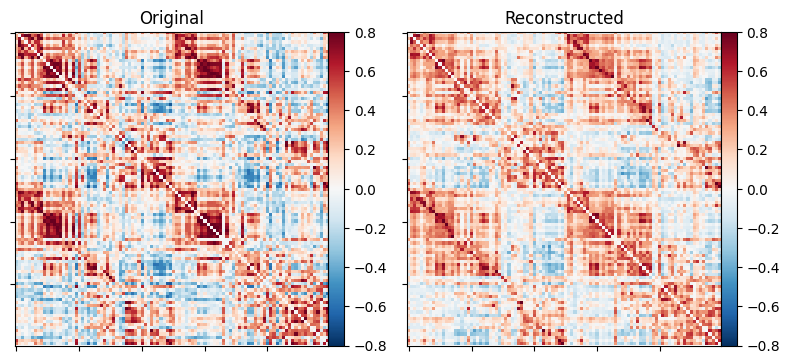

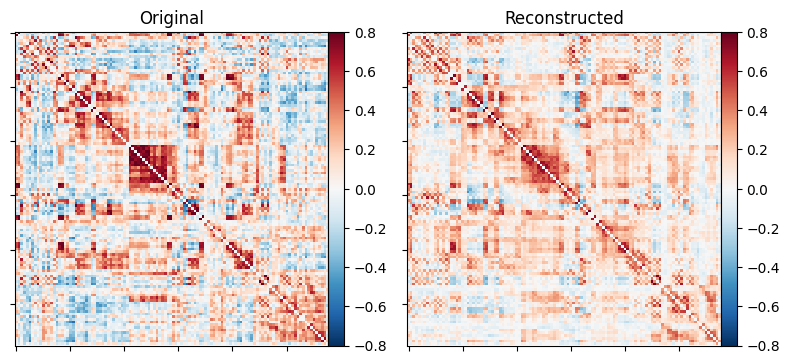

In [5]:
import matplotlib.pyplot as plt
from nilearn import plotting


for k, dataset in enumerate(datasets):
    
    # split the dataset into training and validation sets
    num_samples = len(dataset)
    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    torch.manual_seed(0)
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # define the data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    num_nodes = 116 if atlases[k] == 'aal' else 100
    
    model = VGAE(1, 1, num_nodes, 32, 8, device, dropout=0, l2_strength=0.001, use_nf=False).to(device)
    # load the weights
    model.load_state_dict(torch.load(os.path.join(root, f'vgae_weights/vgae_no_nf_{atlases[k]}_32_8.pt'), map_location=device))

    # select a batch from the validation data loader
    data, _ = next(iter(val_loader))

    edge_index = model.edge_index
    for j in range(min(batch_size, 1)):
        # pass the batch through the trained model to obtain the reconstructed output
        graph = data
        graph = graph[j:j+1].to(device)
        
        recon_edges, z, mu, logvar = model(None, graph)

        recon_edges = recon_edges.detach()

        # Create a SparseTensor object from the edge_index and edge_attr tensors
        recon = torch.zeros((num_nodes, num_nodes))

        for i in range(edge_index.shape[1]):
            recon[edge_index[0,i], edge_index[1,i]] = recon_edges[0][i]
            recon[edge_index[1,i], edge_index[0,i]] = recon_edges[0][i]

        # reshape the output to a 100x100 matrix (assuming the input_dim is 100x100)

        # plot the original and reconstructed matrices for the first sample in the batch
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        plotting.plot_matrix(graph.cpu().view(num_nodes, num_nodes), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax1)
        ax1.set_title('Original')
        plotting.plot_matrix(recon.detach(), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax2)
        ax2.set_title('Reconstructed')
        plt.savefig(f'recon_vgae_nonf_{atlases[k]}')
        plt.show()

In [10]:
for k, dataset in enumerate(datasets):
    
    # split the dataset into training and validation sets
    num_samples = len(dataset)
    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    torch.manual_seed(0)
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # define the data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # load in the models and get the validation loss for each
    models = []
    test_losses = []
    
    
    num_rois = 116 if atlases[k] == 'aal' else 100
    model = VGAE(1, 1, num_rois, 32, 8, device, dropout=0, l2_strength=0.001, use_nf=False).to(device)

    # load the weights
    model.load_state_dict(torch.load(os.path.join(root, f'vgae_weights/vgae_no_nf_{atlases[k]}_32_8.pt'), map_location=device))

    # set the model to evaluation mode
    model.eval()

    src, dest = model.edge_index
    # calculate the validation loss
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, ((graph), _) in enumerate(val_loader):
            graph = graph.to(device)  # move data to device

            rcn_edges, z, mu, logvar = model(None, graph)
            graph = graph[:, src, dest]

            (mse_edges, kl_loss, l2_reg) = model.loss(None, None, rcn_edges.view(graph.shape), graph,
                                                             mu, logvar)
            loss = mse_edges + kl_loss + l2_reg
            val_loss += mse_edges.item()
    print(atlases[k])
    print(val_loss/len(val_dataset))


ica
154.2562255859375
schaefer
167.7855224609375
aal
214.84609646267361


In [ ]:
hidden_dim = 256
latent_dim = 64
input_dim = 100 * 100

model = VGAE(1, 1, 100, 64, 4, device, dropout=0, l2_strength=0.001, use_nf=False).to(device)
# load the weights
model.load_state_dict(torch.load(os.path.join(root, f'vgae_weights/vgae_no_nf.pt'), map_location=device))

psilo_zs = []
hcp_zs = []

with torch.no_grad():
    for batch_idx, (data, _) in enumerate(train_loader):
        _, z, _, _ = model(None, data)
        psilo_zs.append(z)
    
    for batch_idx, (data, _) in enumerate(val_loader):
        _, z, _, _ = model(None, data)
        hcp_zs.append(z)

psilo_zs = torch.cat(psilo_zs, dim=0)
hcp_zs = torch.cat(hcp_zs, dim=0)
        
# Concatenate the encoded representations and create labels
x = torch.cat((psilo_zs, hcp_zs), dim=0)
labels = torch.cat((torch.zeros(psilo_zs.shape[0]), torch.ones(hcp_zs.shape[0])), dim=0)

from sklearn.manifold import TSNE

for per in [10, 20, 30, 40]:
    # Use t-SNE to reduce the dimensionality of the encoded representations
    tsne = TSNE(n_components=2, perplexity=per, n_iter=1000)
    x_tsne = tsne.fit_transform(x)

    # Plot the t-SNE embeddings
    plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels, cmap='coolwarm')
    plt.colorbar()
    plt.title(f'Perplexity {per}')
    plt.savefig(f'tsne-vgae-no-nf-{per}.png')
    plt.show()